# MNIST digit classification before and after shuffling


In this notebook you will use a convolutional neural network (CNN), to train two neural networks on the original and the shuffled MNIST dataset and compare the performances.


**Dataset:** You work with the MNIST dataset. We have 60'000 28x28 pixel greyscale images of digits and want to classify them into the right label (0-9).

**Content:**
* load the original MNIST data and create a randomly shuffled version of the data
* visualize samples of the orginal and shuffled version of the data
* use keras to train a CNN with the original and shuffled data and compare the perfomance on new unseen test data
* check if the local structure of the pixels within the images have an impact on the classification performance when you use a CNN




#### Imports

In the next two cells, we load all the required libraries and functions. We download the Mnist data, normalize the pixelvalues to be between 0 and 1, and seperate it into a training and validation set.

In [18]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers


In [19]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# separate x_train in X_train and X_val, same for y_train
X_train=x_train[0:50000] / 255 #divide by 255 so that they are in range 0 to 1
Y_train=to_categorical(y_train[0:50000],10) # one-hot encoding

X_val=x_train[50000:60000] / 255
Y_val=to_categorical(y_train[50000:60000],10)

X_test=x_test / 255
Y_test=to_categorical(y_test,10)

del x_train, y_train, x_test, y_test

X_train=np.reshape(X_train, (X_train.shape[0],28,28,1))
X_val=np.reshape(X_val, (X_val.shape[0],28,28,1))
X_test=np.reshape(X_test, (X_test.shape[0],28,28,1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


Let's visualize the first 4 mnist images before shuffling the pixels randomly around. It is very easy to recognise the true label of the digits.

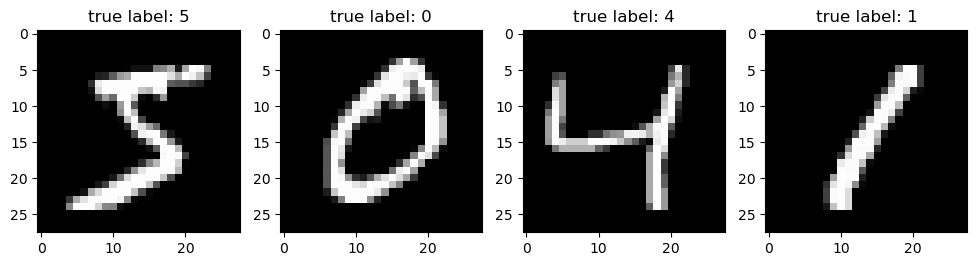

In [20]:
# visualize the 4 first mnist images before shuffling the pixels
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))
    #plt.axis('off')

In the next cell we shuffle the pixel of each image randomly around. Note that we shuffle every image in same manner!

In [21]:
# function to shuffle the pixel order within an image
# used to shuffel the pixels of all mnist images in the same manner
def shuffel_pixels(idx, data):
  data_new=np.zeros((data.shape))
  for i,img in enumerate(data):
    data_new[i] = img.flatten()[idx].reshape((28,28,1))
  return data_new

np.random.seed(42)
shuffel_idx = np.random.permutation(np.arange(28*28))
X_train_shuffle = shuffel_pixels(shuffel_idx, X_train)
X_val_shuffle = shuffel_pixels(shuffel_idx, X_val)
X_test_shuffle = shuffel_pixels(shuffel_idx, X_test)

Let's visualize the first 4 mnist images after shuffling the pixels randomly around. Now as a human you have no chance to recognise the true label of the digits.

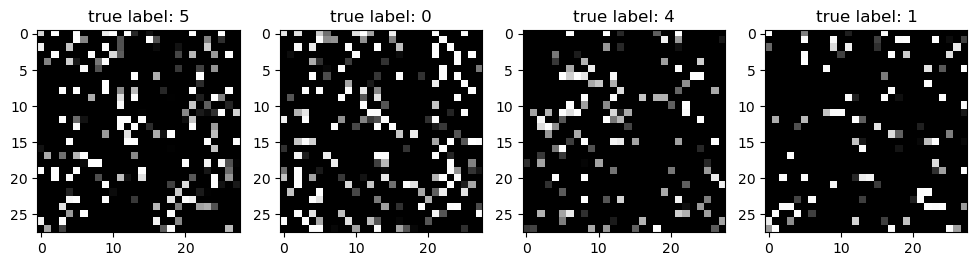

In [22]:
# visualize the 4 first mnist images after shuffling the pixels
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train_shuffle[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))

# CNN as classification model for MNIST data

Now, we train a CNN to classify the MNIST data. We use the same netwok architecture and train first with the original data and then with the shuffled data. 
* Use a CNN with 2 convolution blocks and 2 fully connected layers as classification model
* train it once on the original train data and check the performance on the original test data
* train it once on the shuffeled train data and check the performance on the accordingly shuffled test data

### Train the CNN on the original data

In [6]:
# check the shape of the orginal data
# we need matrices as input
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((50000, 28, 28, 1), (50000, 10), (10000, 28, 28, 1), (10000, 10))

In the next cell we define the hyperparameters and architecture of the CNN. We use:
>the relu activation function  
>batchsize of 128  
>kernelsize of 3x3  
>poolingsize of 2x2   
>our inputs are the greyscaled MNIST images, so the shape is 28x28x1  
> we use 2 convolutional blocks with 8 filters and then a maxpooling layer followed by again 2 convolutional blocks with 16 filters and then a maxpooling  
> then we flatten the output and use a fully connected layer with 40 nodes and the output has 10 nodes with the softmax activation.

In [7]:
# here we define hyperparameter of the CNN
batch_size = 128
nb_classes = 10
img_rows, img_cols = 28, 28
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [8]:
# define CNN with 2 convolution blocks and 2 fully connected layers
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
# summarize model along with number of model weights
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 16)        0

In [10]:
# train the model
history=model.fit(X_train, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=1, 
                  validation_data=(X_val, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 52s 1ms/sample - loss: 0.3802 - accuracy: 0.8853 - val_loss: 0.1318 - val_accuracy: 0.9622
Epoch 2/10
50000/50000 [==============================] - 53s 1ms/sample - loss: 0.1010 - accuracy: 0.9688 - val_loss: 0.0847 - val_accuracy: 0.9760
Epoch 3/10
50000/50000 [==============================] - 53s 1ms/sample - loss: 0.0689 - accuracy: 0.9785 - val_loss: 0.0617 - val_accuracy: 0.9818
Epoch 4/10
50000/50000 [==============================] - 57s 1ms/sample - loss: 0.0545 - accuracy: 0.9827 - val_loss: 0.0535 - val_accuracy: 0.9843
Epoch 5/10
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.0471 - accuracy: 0.9850 - val_loss: 0.0504 - val_accuracy: 0.9847
Epoch 6/10
50000/50000 [==============================] - 53s 1ms/sample - loss: 0.0385 - accuracy: 0.9876 - val_loss: 0.0455 - val_accuracy: 0.9873
Epoch 7/10
50000/50000 [==============================] 

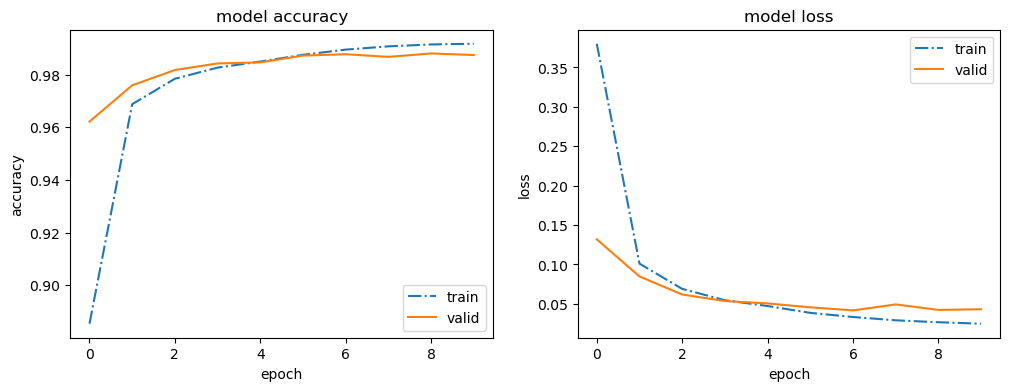

In [11]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

#### Prediction on the test set after training on original data

Now, let's use CNN that was trained on the original data to predict new unseen data (our testdata). We determine the confusion matrix and the accuracy on the testdata to evaluate the classification performance.

In [12]:
pred=model.predict(X_test)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_cnn= " , acc)

[[ 977    0    0    0    0    0    2    0    1    0]
 [   0 1130    1    0    0    0    1    0    3    0]
 [   1    1 1024    0    0    0    0    5    1    0]
 [   0    0    0 1006    0    2    0    1    1    0]
 [   1    1    0    0  973    0    1    1    1    4]
 [   3    0    0   11    0  868    3    1    5    1]
 [  10    2    0    0    3    1  939    0    3    0]
 [   1    2    5    3    1    0    0 1007    1    8]
 [   3    0    4    2    0    0    0    3  960    2]
 [   1    1    0    2    4    1    0    3    9  988]]
Acc_cnn_orig =  0.9872


### Train the CNN on the shuffled data

In [13]:
# check the shape of the shuffled data
# we need matrices as input
X_train_shuffle.shape,Y_train.shape,X_val_shuffle.shape,Y_val.shape

((50000, 28, 28, 1), (50000, 10), (10000, 28, 28, 1), (10000, 10))

In [14]:
# define CNN with 2 convolution blocks and 2 fully connected layers  
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
# train the model
history=model.fit(X_train_shuffle, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=1, 
                  validation_data=(X_val_shuffle, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 56s 1ms/sample - loss: 0.7068 - accuracy: 0.7801 - val_loss: 0.3474 - val_accuracy: 0.8940
Epoch 2/10
50000/50000 [==============================] - 62s 1ms/sample - loss: 0.3162 - accuracy: 0.9047 - val_loss: 0.2563 - val_accuracy: 0.9279
Epoch 3/10
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.2385 - accuracy: 0.9283 - val_loss: 0.2097 - val_accuracy: 0.9366
Epoch 4/10
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.1946 - accuracy: 0.9415 - val_loss: 0.1754 - val_accuracy: 0.9461
Epoch 5/10
50000/50000 [==============================] - 61s 1ms/sample - loss: 0.1629 - accuracy: 0.9502 - val_loss: 0.1574 - val_accuracy: 0.9516
Epoch 6/10
50000/50000 [==============================] - 56s 1ms/sample - loss: 0.1422 - accuracy: 0.9562 - val_loss: 0.1574 - val_accuracy: 0.9515
Epoch 7/10
50000/50000 [==============================] 

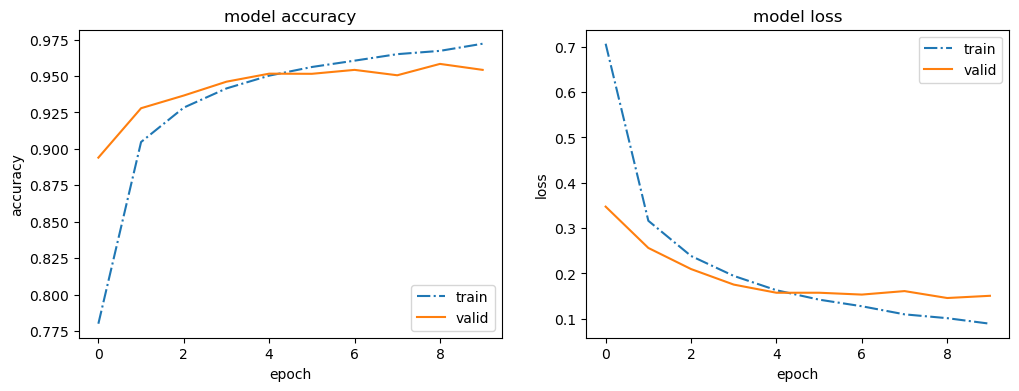

In [16]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

#### Prediction on the test set after training on the shuffled data

Use the CNN that was trained on the shuffled data to predict new unseen data (our testdata). We determine the confusion matrix and the accuracy on the testdata to evaluate the classification performance.


In [23]:
pred=model.predict(X_test_shuffle)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_cnn= " , acc)

[[ 958    0    6    1    0    6    3    1    2    3]
 [   0 1120    4    1    1    0    3    0    5    1]
 [   5    2 1000    8    4    1    2    3    7    0]
 [   0    1   17  963    0   15    0    4    7    3]
 [   0    1   15    0  937    1    6    2    2   18]
 [   5    0    0   21    1  851    6    0    6    2]
 [   6    5    8    3    4    7  920    1    3    1]
 [   0   10   17    9    5    0    1  960    3   23]
 [   1    1   13   22    8   11    3    6  903    6]
 [   1    5    4    9   20   14    0    7    6  943]]
Acc_cnn=  0.9555


#### Exercise

Compre the performances of the fcNN on the MNIST dataset to the CNN performances.  
What do you observe?  
Compre the performance of the CNN on the original and on the shuffled dataset.  
Try to explain the differences.  
What could you do to improve the performance of the CNN on the shuffled dataset?

